In [ ]:
import os
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')
data_dir = '/content/gdrive/My Drive/PassingGraph'

# Define the filename for the graphs array
graphs_filename = 'graphs.pkl'
graphs_filepath = os.path.join(data_dir, graphs_filename)

# Read the graphs array from the file
with open(graphs_filepath, 'rb') as f:
    graphs = pickle.load(f)

Mounted at /content/gdrive


In [ ]:
graphs[0]

[[(0, 1, 1),
  (0, 2, 2),
  (0, 3, 5),
  (0, 6, 1),
  (0, 8, 1),
  (0, 10, 2),
  (1, 0, 1),
  (1, 2, 3),
  (1, 4, 1),
  (1, 5, 4),
  (1, 6, 4),
  (1, 7, 1),
  (1, 8, 2),
  (2, 1, 1),
  (2, 3, 3),
  (2, 5, 1),
  (2, 7, 2),
  (2, 8, 1),
  (2, 10, 1),
  (3, 0, 1),
  (3, 2, 1),
  (3, 4, 2),
  (3, 6, 1),
  (3, 7, 1),
  (3, 10, 2),
  (4, 6, 1),
  (4, 8, 4),
  (4, 9, 1),
  (4, 10, 5),
  (5, 1, 3),
  (5, 2, 2),
  (5, 3, 1),
  (5, 4, 4),
  (5, 7, 1),
  (5, 8, 1),
  (5, 9, 1),
  (5, 10, 3),
  (6, 1, 4),
  (6, 2, 1),
  (6, 10, 4),
  (7, 1, 1),
  (7, 2, 2),
  (7, 3, 1),
  (7, 5, 1),
  (7, 6, 2),
  (7, 8, 3),
  (7, 9, 2),
  (8, 0, 1),
  (8, 4, 3),
  (8, 5, 1),
  (8, 6, 2),
  (8, 7, 1),
  (8, 9, 4),
  (9, 4, 2),
  (9, 5, 2),
  (9, 6, 3),
  (9, 8, 1),
  (10, 2, 1),
  (10, 6, 4),
  (10, 7, 2),
  (10, 8, 2),
  (10, 9, 1)],
 array([[ 6.98888889, 40.69047619, 12.        ,  0.        ],
        [41.84655172, 64.93275862, 16.        ,  1.        ],
        [29.38333333, 51.41666667,  9.        ,  1.       

In [ ]:
!pip install spektral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
from spektral.data import Dataset, Graph
import numpy as np
import scipy.sparse as sp

class CustomDataset(Dataset):
    """
    A dataset of custom graphs.
    """

    def __init__(self, graphs, **kwargs):
        self.graphs = graphs
        super().__init__(**kwargs)

    def read(self):
        def make_graph(graph_data):
            adjacency_list, node_features, label = graph_data

            # Convert adjacency list to sparse adjacency matrix
            n_nodes = len(node_features)
            adj_matrix = np.zeros((n_nodes, n_nodes))
            for edge in adjacency_list:
                src, dst, _ = edge
                adj_matrix[src, dst] = 1

            # Create Graph object
            return Graph(
                x=node_features,
                a=sp.csr_matrix(adj_matrix),
                y=label
            )

        return [make_graph(graph_data) for graph_data in self.graphs]

In [ ]:
print(type(graphs))

<class 'list'>


In [ ]:
graphs_list = list(graphs)
dataset = CustomDataset(graphs)


In [ ]:
dataset[0]

Graph(n_nodes=11, n_node_features=4, n_edge_features=None, n_labels=1)

In [ ]:
!pip install tensorflow

In [ ]:
from ipywidgets import Checkbox, Dropdown, Accordion, VBox
import sklearn.metrics as metrics
from sklearn.calibration import calibration_curve
from spektral.data import Dataset, Graph, DisjointLoader
from spektral.layers import CrystalConv, GlobalAvgPool
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import copy
import logging
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import random
import sys
import tensorflow as tf
import requests
import progressbar
from os.path import isfile
import time

# Setting up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
stdout_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_handler)

In [ ]:
N = max(g.n_nodes for g in dataset) # Number of nodes
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
n = len(dataset) # Number of samples in the dataset

# Train/test split for the dataset
idxs = np.random.RandomState(seed=15).permutation(len(dataset))
split_va, split_te = int(0.7 * len(dataset)), int(0.69 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
dataset_tr = dataset[idx_tr]
dataset_te = dataset[idx_te]
loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1, shuffle = False)

# Display dataset information on target variable.
logger.info(f"n: {n}")
logger.info(f"Pct successful total: {round(np.asarray([graph.y for graph in dataset]).sum() / n, 2)}")
logger.info(f"Pct successful train: {round(np.asarray([graph.y for graph in dataset_tr]).sum() / (n * .7), 2)}")
logger.info(f"Pct successful test: {round(np.asarray([graph.y for graph in dataset_te]).sum() / (n * .3), 2)}")

n: 1734
n: 1734


INFO:__main__:n: 1734


Pct successful total: 0.4
Pct successful total: 0.4


INFO:__main__:Pct successful total: 0.4


Pct successful train: 0.4
Pct successful train: 0.4


INFO:__main__:Pct successful train: 0.4


Pct successful test: 0.42
Pct successful test: 0.42


INFO:__main__:Pct successful test: 0.42


In [ ]:
learning_rate = 1e-3  # Learning rate
epochs = 200  # Number of training epochs
batch_size = 16  # Batch size
channels = 128  # Hidden units for the neural network
layers = 3  # Number of CrystalConv layers

In [ ]:
class GNN(Model):
    '''
    Building the Graph Neural Network configuration with Model as the parent class
    from spektral library.
    '''
    def __init__(self, n_layers):
        '''
        Constructor code for setting up the layers needed for training the model.
        '''
        super().__init__()
        self.conv1 = CrystalConv()
        self.convs = []
        for _ in range(1, n_layers):
            self.convs.append(
                CrystalConv()
            )
        self.pool = GlobalAvgPool()
        self.dense1 = Dense(channels, activation="relu")
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(channels, activation="relu")
        self.dense3 = Dense(n_out, activation="sigmoid")

    def call(self, inputs):
        '''
        Build the neural network.
        '''
        x, a, i = inputs
        x = self.conv1([x, a])
        for conv in self.convs:
            x = conv([x, a ])
        x = self.pool([x, i])
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        return self.dense3(x)


# Build model
model = GNN(layers)
# Setup the optimizer
optimizer = Adam(learning_rate)
# Set up the logloss function
loss_fn = BinaryCrossentropy()

In [ ]:
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# Print loss at each step of training.
step = loss = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
        loss = 0

/usr/local/lib/python3.10/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'CustomDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Loss: 83.58500671386719
Loss: 11.388094902038574
Loss: 6.041434288024902
Loss: 3.6541500091552734
Loss: 2.6411337852478027
Loss: 1.7482352256774902
Loss: 1.3415968418121338
Loss: 1.0406235456466675
Loss: 0.9470637440681458
Loss: 0.8085496425628662
Loss: 0.7760348320007324
Loss: 0.7434315085411072
Loss: 0.7018100023269653
Loss: 0.6862584948539734
Loss: 0.690902590751648
Loss: 0.6938380599021912
Loss: 0.7023829221725464
Loss: 0.6736792325973511
Loss: 0.6683160662651062
Loss: 0.6537657976150513
Loss: 0.6594169735908508
Loss: 0.633569061756134
Loss: 0.6636658310890198
Loss: 0.6402208209037781
Loss: 0.6340547800064087
Loss: 0.6619020700454712
Loss: 0.6477918028831482
Loss: 0.6480008959770203
Loss: 0.6360523700714111
Loss: 0.6471264958381653
Loss: 0.6355108022689819
Loss: 0.6365881562232971
Loss: 0.6325584053993225
Loss: 0.6332335472106934
Loss: 0.6373845934867859
Loss: 0.618546187877655
Loss: 0.6255853772163391
Loss: 0.6150614023208618
Loss: 0.6245913505554199
Loss: 0.6198857426643372
Loss:

Testing Model...
Testing Model...


INFO:__main__:Testing Model...


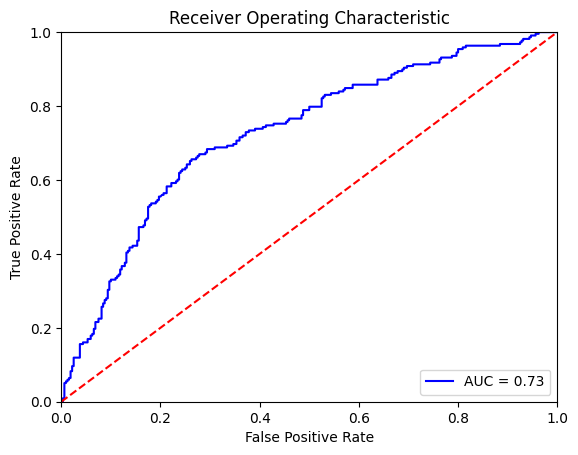

In [ ]:
logger.info("Testing Model...")

y_true = []
y_pred = []

# Add the true values and the predicted values in the list
for batch in loader_te:
    inputs, target = batch
    p = model(inputs, training=False)
    y_true.append(target)
    y_pred.append(p.numpy())

# Calculate the ROC-AUC metric
y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)
fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC w/ True positive rate on the y-axis and False positive rate on the x-axis.
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Iterate over true labels and predicted scores simultaneously
for y_true, y_pred in zip(y_true, y_pred):
    print("True Label: {}, Predicted Score: {}".format(y_true, y_pred))


True Label: [0], Predicted Score: [0.23879316]
True Label: [0], Predicted Score: [0.37076905]
True Label: [0], Predicted Score: [0.26817244]
True Label: [1], Predicted Score: [0.4435927]
True Label: [1], Predicted Score: [0.5157559]
True Label: [1], Predicted Score: [0.63286537]
True Label: [0], Predicted Score: [0.46184692]
True Label: [1], Predicted Score: [0.4551927]
True Label: [0], Predicted Score: [0.2548186]
True Label: [1], Predicted Score: [0.5092348]
True Label: [1], Predicted Score: [0.5667975]
True Label: [1], Predicted Score: [0.5322253]
True Label: [0], Predicted Score: [0.5245579]
True Label: [1], Predicted Score: [0.30916256]
True Label: [1], Predicted Score: [0.6942045]
True Label: [1], Predicted Score: [0.46205717]
True Label: [0], Predicted Score: [0.44557112]
True Label: [1], Predicted Score: [0.23112835]
True Label: [0], Predicted Score: [0.29409117]
True Label: [1], Predicted Score: [0.39185652]
True Label: [0], Predicted Score: [0.24264148]
True Label: [0], Predi